<a href="https://colab.research.google.com/github/Aniket18-bot/E-Waste-Generation-Classification/blob/main/E_waste_Generation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🗑️ E-Waste Image Classification -

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aniketredekar","key":"aace9d4896a37c20dba7ea69fb0acc24"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download akshat103/e-waste-image-dataset

Dataset URL: https://www.kaggle.com/datasets/akshat103/e-waste-image-dataset
License(s): apache-2.0
  0% 0.00/11.8M [00:00<?, ?B/s]
100% 11.8M/11.8M [00:00<00:00, 900MB/s]


In [4]:
!unzip e-waste-image-dataset.zip -d e-waste-image-dataset

Archive:  e-waste-image-dataset.zip
  inflating: e-waste-image-dataset/modified-dataset/test/Battery/battery_106.jpg  
  inflating: e-waste-image-dataset/modified-dataset/test/Battery/battery_128.jpg  
  inflating: e-waste-image-dataset/modified-dataset/test/Battery/battery_148.jpg  
  inflating: e-waste-image-dataset/modified-dataset/test/Battery/battery_152.jpg  
  inflating: e-waste-image-dataset/modified-dataset/test/Battery/battery_174.jpg  
  inflating: e-waste-image-dataset/modified-dataset/test/Battery/battery_177.jpg  
  inflating: e-waste-image-dataset/modified-dataset/test/Battery/battery_190.jpg  
  inflating: e-waste-image-dataset/modified-dataset/test/Battery/battery_192.jpg  
  inflating: e-waste-image-dataset/modified-dataset/test/Battery/battery_211.jpg  
  inflating: e-waste-image-dataset/modified-dataset/test/Battery/battery_22.jpg  
  inflating: e-waste-image-dataset/modified-dataset/test/Battery/battery_24.jpg  
  inflating: e-waste-image-dataset/modified-dataset/t

In [5]:
import os


data_dir = "e-waste-image-dataset/modified-dataset"
print("Root contains:\n", os.listdir(data_dir))


sample_subfolder = os.path.join(data_dir, "train")
print("\nContents inside train:\n", os.listdir(sample_subfolder)[:10])

Root contains:
 ['train', 'val', 'test']

Contents inside train:
 ['Mobile', 'Player', 'Television', 'Keyboard', 'Microwave', 'PCB', 'Washing Machine', 'Printer', 'Mouse', 'Battery']


In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

# Set paths for train, val, test directories
base_path = "e-waste-image-dataset/modified-dataset"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

# Load datasets
img_size = (128, 128)
batch_size = 32

train_ds = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Print class names
class_names = train_ds.class_names
print("\nClasses:", class_names)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.

Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


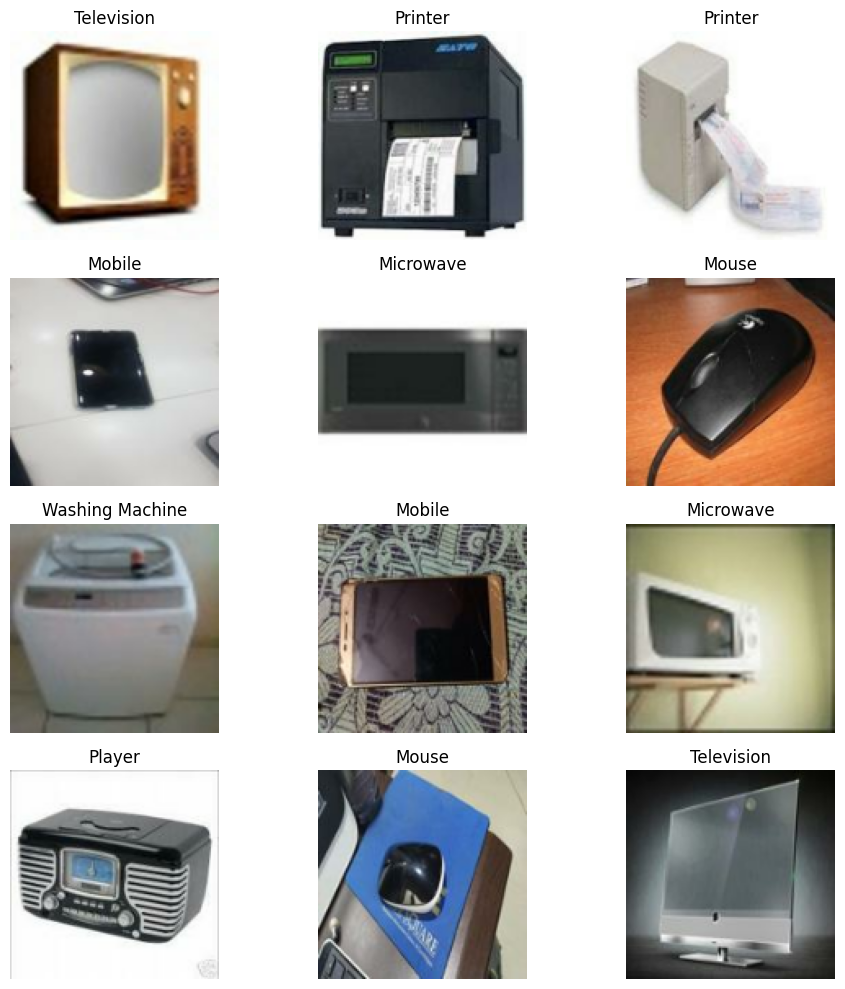

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.tight_layout()
plt.show()

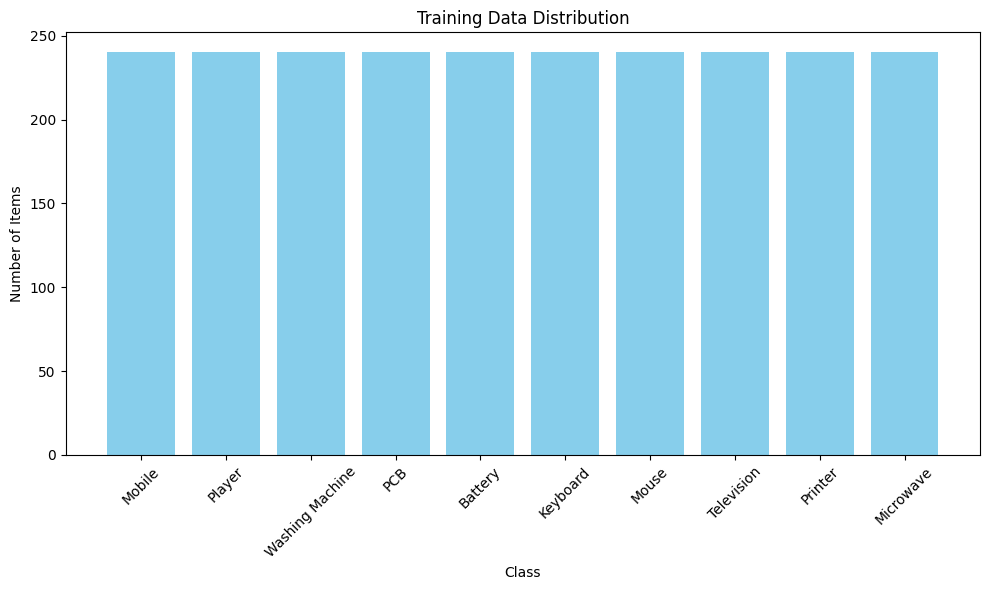

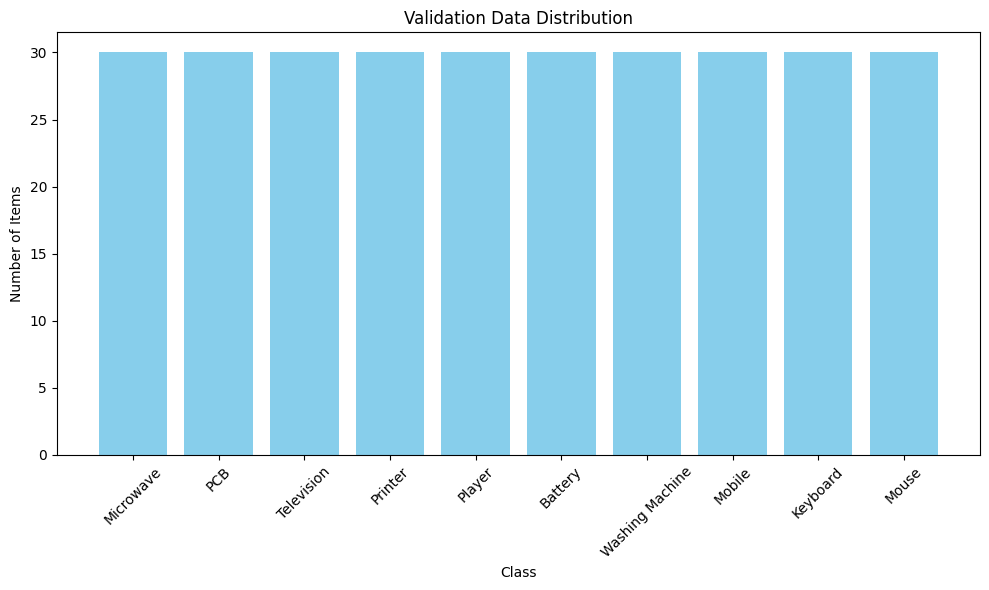

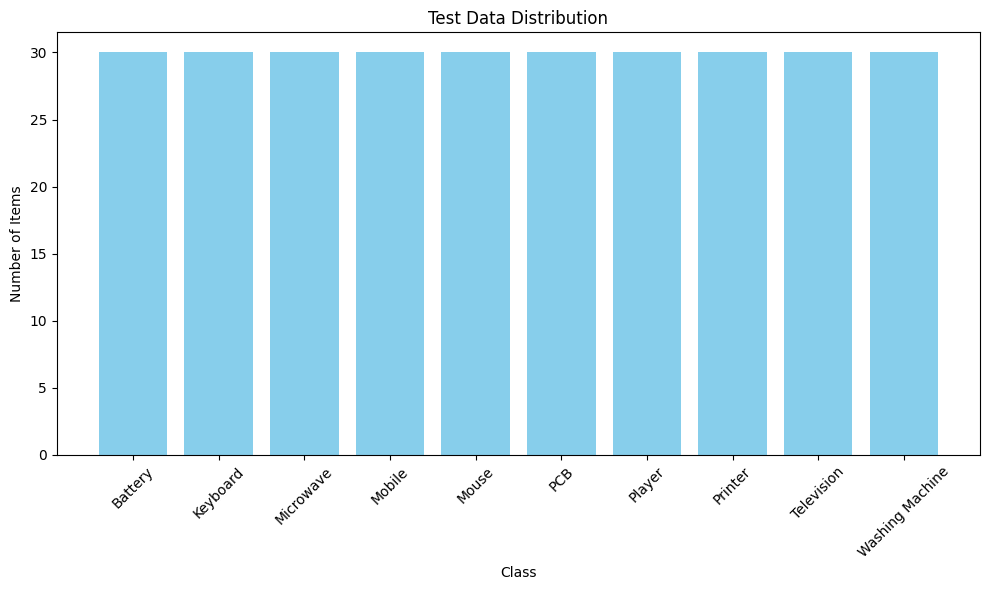

In [8]:
#Class distribution function + plots
def plot_class_distribution(dataset, title):
    class_counts = {}
    for images, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Items")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_ds, "Training Data Distribution")
plot_class_distribution(val_ds, "Validation Data Distribution")
plot_class_distribution(test_ds, "Test Data Distribution")

In [9]:
#Data augmentation
import tensorflow as tf # Import the tensorflow library

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [10]:
#Base model selection
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
#Model creation
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [12]:
#Model compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['Accuracy']
)

In [13]:
#Early stopping
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [17]:
#Train model
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=100,
    callbacks=[early]
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - Accuracy: 0.9841 - loss: 0.0625 - val_Accuracy: 0.9500 - val_loss: 0.1500
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - Accuracy: 0.9852 - loss: 0.0644 - val_Accuracy: 0.9533 - val_loss: 0.1418
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - Accuracy: 0.9888 - loss: 0.0487 - val_Accuracy: 0.9667 - val_loss: 0.1346
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - Accuracy: 0.9926 - loss: 0.0376 - val_Accuracy: 0.9667 - val_loss: 0.1395
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - Accuracy: 0.9907 - loss: 0.0383 - val_Accuracy: 0.9633 - val_loss: 0.1347
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - Accuracy: 0.9957 - loss: 0.0310 - val_Accuracy: 0.9600 - val_loss: 0.1312
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - Accuracy: 0.9936 - loss: 0.0258 - val_Accuracy: 0.9633 - val_loss: 0.1405
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - Accuracy: 0.9893 - loss: 0.0373 - val_Accuracy: 0.9600 - v

In [19]:
# Print the architecture summary of the  model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

In [20]:
 # Print the architecture summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 32, 32,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 32, 32,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 32, 32,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

In [21]:
#Evaluate model
import numpy as np
import seaborn as sns
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - Accuracy: 0.9351 - loss: 0.1817
Test accuracy is 0.9433, Test loss is 0.1380


In [22]:
#Confusion matrix + classification report
from sklearn.metrics import confusion_matrix, classification_report
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 723ms/step
[[26  0  0  0  1  2  1  0  0  0]
 [ 1 29  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  1  0  0]
 [ 0  0  0 29  0  1  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  1 28  1  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  1  0 29  0  0]
 [ 0  0  2  1  0  1  1  0 25  0]
 [ 0  0  0  0  0  0  1  0  0 29]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.91        30
           1       1.00      0.97      0.98        30
           2       0.94      0.97      0.95        30
           3       0.97      0.97      0.97        30
           4       0.94      0.97      0.95        30
           5       0.85      0.93      0.89        30
           6       0.88      1.00      0.94        30
           7       0.94      0.97      0.95        30
           8       1.00      0.83      0.91        30
           9       1.00      0.97      0.98        30

    accuracy                   

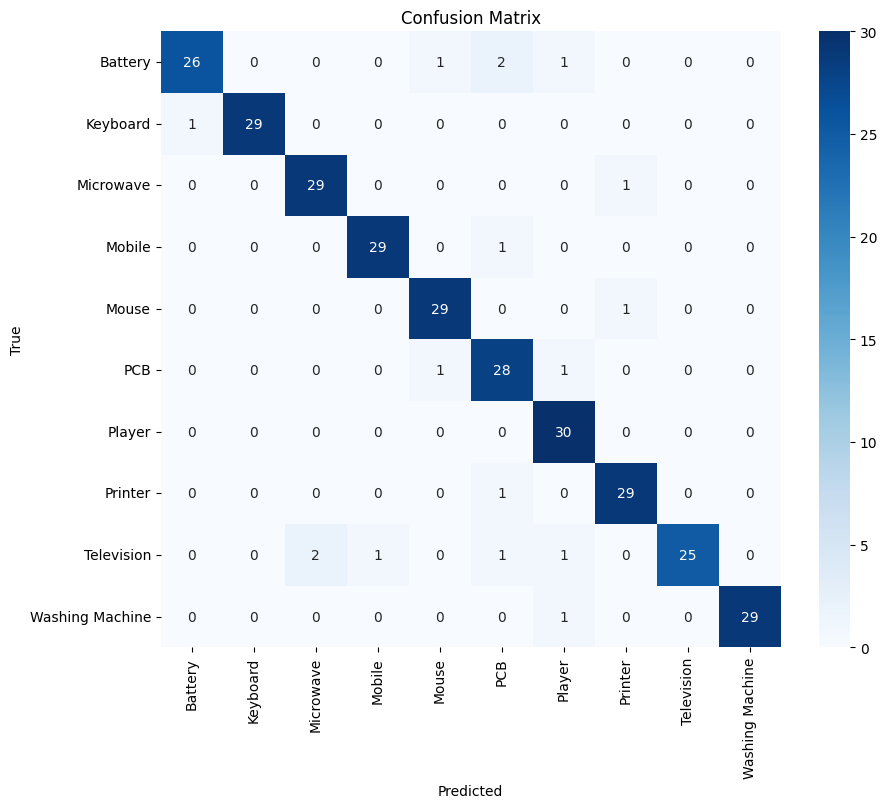

In [23]:
#Confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

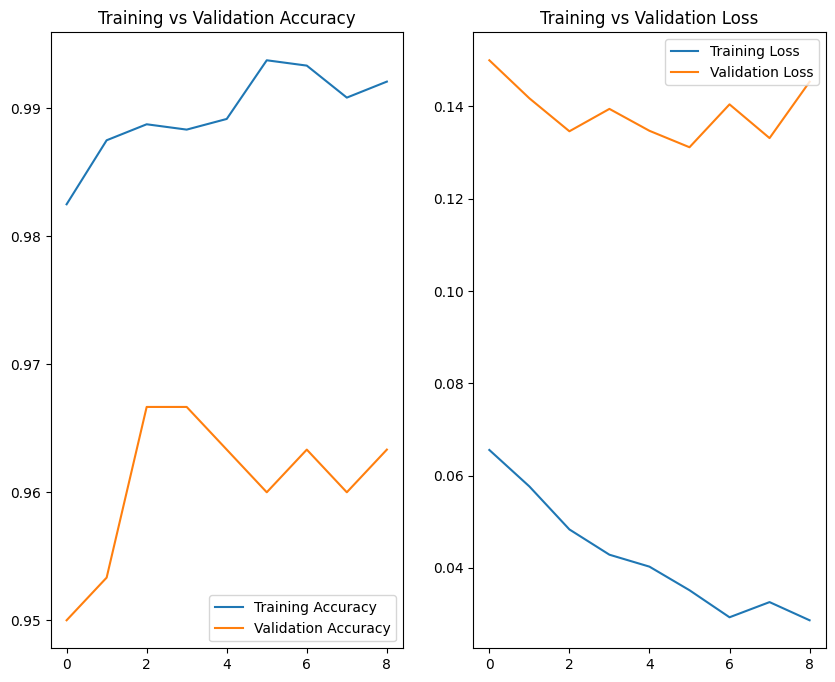

In [24]:
#Accuracy / loss trend plots
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


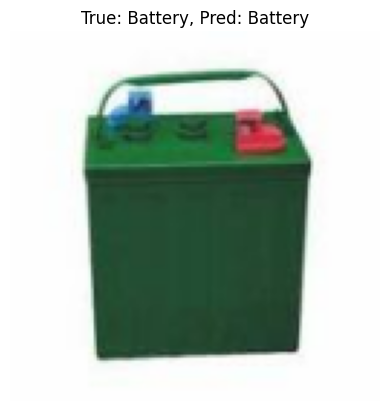

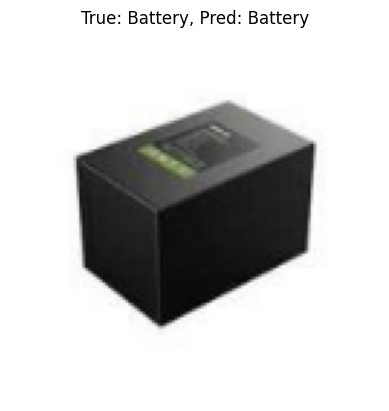

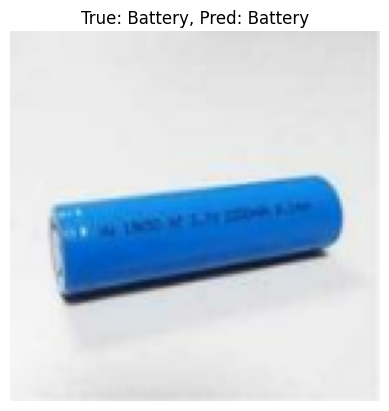

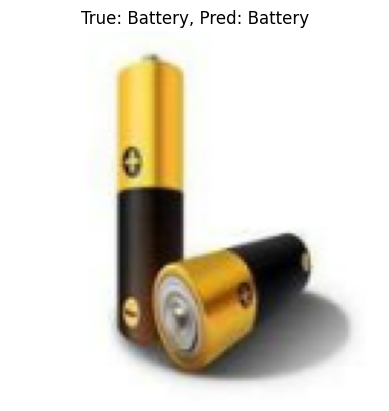

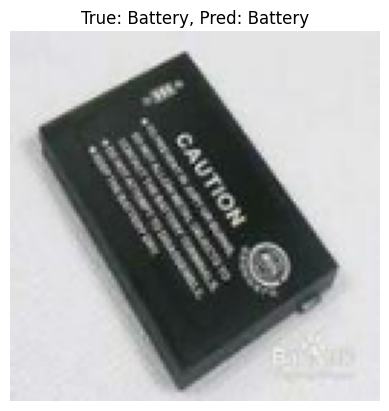

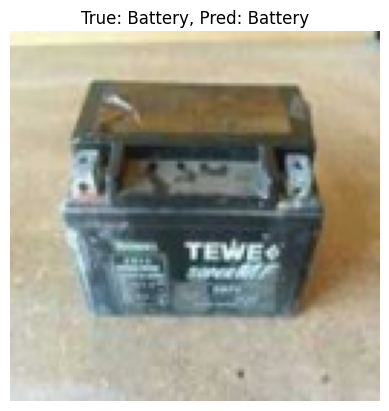

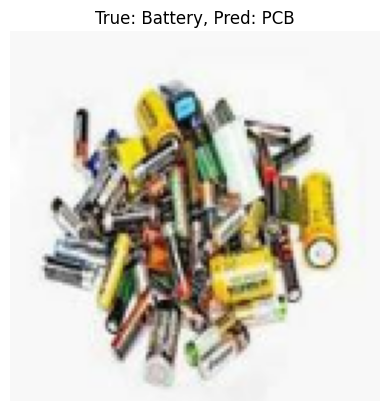

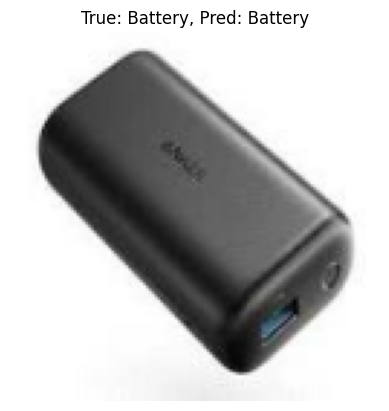

In [26]:
#Displaying Predictions on Test Data
class_names = test_ds.class_names

for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()

In [27]:
#Save the Trained Model
model.save("Efficient_classify.keras")

In [38]:
#Load Model
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']
model = tf.keras.models.load_model("Efficient_classify.keras")

In [45]:
import gradio as gr
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import tensorflow as tf
import os

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')


# Load saved model
model = load_model("Efficient_classify.keras")

# Class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse',
               'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Preprocess and classify image
def classify_image(img):
    img = img.resize((128, 128))
    # Convert PIL image to TensorFlow tensor with explicit shape
    img_tensor = tf.convert_to_tensor(np.array(img, dtype=np.float32))
    img_tensor = tf.expand_dims(img_tensor, axis=0)

    img_array = preprocess_input(img_tensor)


    prediction = model.predict(img_array)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"🔍 Predicted: {class_name}\n📊 Confidence: {confidence:.2%}"

# Launch improved Gradio interface
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil", label="Upload E-Waste Image"),
    outputs=gr.Textbox(label="Prediction"),
    title="E-Waste Image Classifier",
    description="Upload an E-Waste image to classify it.",
    theme="default"
)

interface.launch(share=True,debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9cf527501477bbd9e7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7863 <> https://9cf527501477bbd9e7.gradio.live
